In [77]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from jaqalpaq import run
from jaqalpaq import emulator
from jaqalpaq.run import run_jaqal_file, run_jaqal_string, run_jaqal_batch, run_jaqal_circuit, frontend
# from jaqalpaq.run import * (identical to from jaqalpaq import run aside from needing "run" before everything)
# from jaqalpaq.run import frontend (needed to switch between emulator and experiment)
from jaqalpaq.parser import parse_jaqal_string

## 3 qubits

### Measure crosstalk with rabi oscillations

In [78]:
#Create a jaqal code (string method)

SingleIonRabi = f"""
//Comment via a double forward slash in jaqal strings

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha 0.1
let qtarget 1

//Select your register of qubits
register q[3]

//jaqal circuit
prepare_all
Rx q[qtarget] alpha
measure_all
"""

In [79]:

angles = list(np.linspace(0,40*np.pi, 100))

results = []

for t in np.arange(qnum):
    #override dictionary
    override_dict={ "alpha": angles,
               "qtarget": t,
                "__repeats__": 100}

    #Run the circuit with the parameters being overwritten
    res = run_jaqal_string(SingleIonRabi, overrides=override_dict)
    results.append(res)


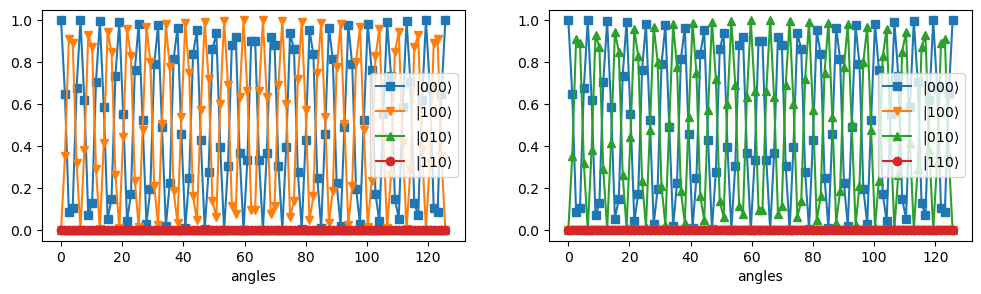

In [80]:
fig,axs = plt.subplots(1,qnum,figsize=(12,3))

num_states = 2**qnum

for i in np.arange(qnum):
    res = results[i]
    outcomes = [[] for _ in range(num_states)]
    for r in res.by_subbatch:
        for n in range(num_states):
            outcomes[n].append(r.by_subcircuit[0].simulated_probabilities.by_int_dense[n])
     
    for n in range(num_states):
        axs[i].plot(angles, 
             outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:03b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
    axs[i].legend()
    axs[i].set_xlabel("angles")

plt.show()

### Adiabatic Molmer Sorensen

#### Populations

In [81]:
MSPop = f"""

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha 0.1
let t1 1
let t2 2

//Select your register of qubits
register q[3]

//jaqal circuit
prepare_all
MS q[t1] q[t2] 0 alpha
measure_all
"""

In [82]:
angles = list(np.linspace(0,2*np.pi, 100))
t1 = 0
t2 = 1

results = []

override_dict={ "alpha": angles,
               "t1": t1,
                   "t2":t2,
                "__repeats__": 100}

#Run the circuit with the parameters being overwritten
res = run_jaqal_string(MSPop, overrides=override_dict)
results.append(res)

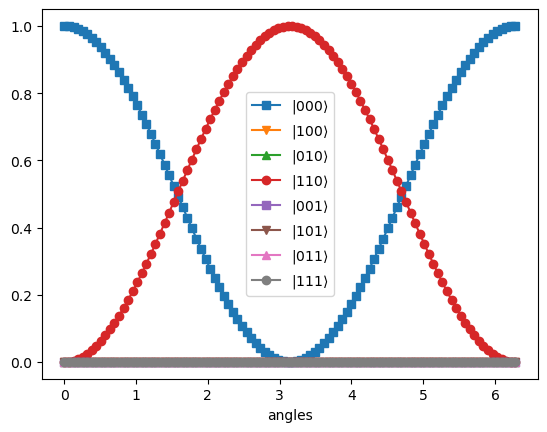

In [83]:
fig,ax = plt.subplots()

num_states = 2**3

res = results[0]
outcomes = [[] for _ in range(num_states)]
for r in res.by_subbatch:
    for n in range(num_states):
        outcomes[n].append(r.by_subcircuit[0].simulated_probabilities.by_int_dense[n])
     
for n in range(num_states):
    ax.plot(angles, 
            outcomes[n], 
             label=f"$\\left\\vert{''.join(reversed(f'{n:03b}'))}\\right\\rangle$", 
             marker="sv^o"[n%4])
ax.legend()
ax.set_xlabel("angles")

plt.show()

#### MS Parity

In [84]:
MSParity = f"""

//Pulse Definitions Import Statement
from qscout.v1.std usepulses *

//Define let parameters
let alpha {np.pi/2.}
let eta 0.0
let t1 0
let t2 1

let beta 0.1
let beta2 {np.pi/2.}

//Select your register of qubits
register q[3]

//jaqal circuit
prepare_all
MS q[t1] q[t2] eta alpha
<R q[0] beta beta2 | R q[1] beta beta2 | R q[2] beta beta2> 
measure_all
"""

In [85]:
angles = list(np.linspace(0,2*np.pi, 100))
qnum = 2
t1 = 0
t2 = 1

#override dictionary
override_dict={"beta":angles,
               "qnum": qnum,
               "t1": t1,
                   "t2":t2,
                "__repeats__": 100}

#Run the circuit with the parameters being overwritten
res = run_jaqal_string(MSParity, overrides=override_dict)

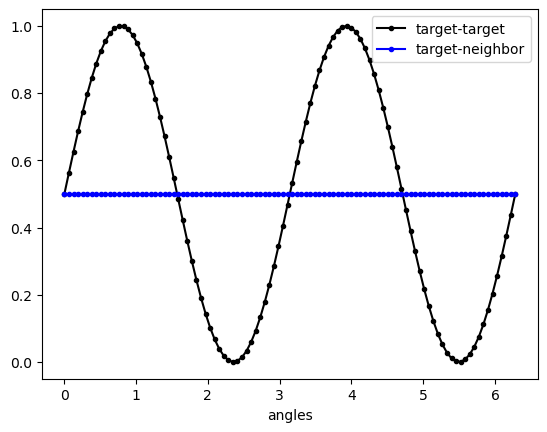

In [99]:
fig,ax = plt.subplots()

num_states = 2**3

#iterate through parameters
outcomes = [[] for _ in range(num_states)]
for r in res.by_subbatch:
    for n in range(num_states):
        outcomes[n].append(r.by_subcircuit[0].simulated_probabilities.by_int_dense[n])

parityTarget = np.array(outcomes[0]) + np.array(outcomes[4]) + np.array(outcomes[3]) + np.array(outcomes[7]) 
- np.array(outcomes[1]) - np.array(outcomes[2]) - np.array(outcomes[5]) - np.array(outcomes[6])  

parityTargetNeighbor = np.array(outcomes[0]) + np.array(outcomes[2]) + np.array(outcomes[5]) + np.array(outcomes[7]) 
- np.array(outcomes[1]) - np.array(outcomes[3]) - np.array(outcomes[4]) - np.array(outcomes[6])  

ax.plot(angles,parityTarget,'.-k',label='target-target')
ax.plot(angles,parityTargetNeighbor,'.-b',label='target-neighbor')

ax.legend()
ax.set_xlabel("angles")

plt.show()